# **Understanding natural language opinions**
## **with Topic Modeling and Summarization techniques.**

### Objetivos:

    Identificar las temáticas subyacentes al conjunto de opiniones.
    Facilitar la comprensión de las ideas y conceptos más sobresalientes en la Cognicion Colectiva de los usuarios.
    Automatizar este proceso que a un humano podría llevarle demasiado tiempo.    

## Preprocess

In [1]:
path_to_MyModule = '..'

import sys
sys.path.insert(0, path_to_MyModule) 

import pandas as pd
import matplotlib.pyplot as plt
from time import sleep

from MyModule.GeneralFunctions import *
from MyModule.SummarizationFunctions import *
from MyModule.SamplingFunctions import *
from MyModule.SemanticSimilarityFunctions import *
from MyModule.TopicModelingFunctinos import *

In [2]:
df = pd.read_excel('..\datos.xlsx')[['ID','texto','desafio']]

In [3]:
# Limpieza
df.drop_duplicates(subset='texto', inplace=True)

# Quitando texto de mas en columna "desafio"
df['desafio'] = df['desafio'].apply(lambda x: re.findall('[0-9]+', x)[0])

# A str
df['texto'] = df['texto'].astype(str)

## Select a desafio and n_clusters

In [257]:
data = df[df['desafio']=='18']['texto'].values

n_clusters = 5

## Select the most representative documents of each desafio's cluster

1. Obtener un vector semántico para cada documento (utilizando SentenceTransformers)
2. Clusterizar los documentos en base a sus vectores (utilizando KMeans o HDBScan)
3. Evaluar la similitud coseno de cada documento con el centroide de su cluster
4. Devolver los documentos ordenados de mayor a menos similitud

Así, los documentos son presentados en el orden en el que más capturan el significado y las ideas expresadas por la mayoria.

In [5]:
from MyModule.SummarizationFunctions import MostRepresentativeDocs

pp_object = Preprocess(lemma=False, stopwords=False)
mrd = MostRepresentativeDocs(cluster_algorithm='kmeans')

In [16]:
# all_res = {}
# for des in df['desafio'].unique():
#     this_data = df[df['desafio']==des]['texto'].values.tolist()
#     result = mrd.get_representatives(this_data, 5, pp_object)
#     all_res[des] = result

In [291]:
result = mrd.get_representatives(data, n_clusters=n_clusters, pp_object=pp_object)

In [189]:
mrd.get_average_silhouette_score()

0.1682066

In [396]:
result[0]

[('La carga horaria, drena mucho y cuando uno vuelve a su casa y quiere estudiar, físicamente no puede porque termina agotado de cursar casi 12 horas (en algunos casos). También, noto muchísima diferencia ente cátedras de una misma materia. Pueden entrar hasta menos temas y las pruebas pueden ser de menor dificultad y se sigue tratando de una misma materia. Un grupo puede llegar a recursar por su dificultad, mientras que al otro que le entran menos temas y de menor dificultad, puede cerrar la materia con un promedio alto.',
  0.81566155),
 ('La poca seriedad que le ponen muchos de los estudiantes, parece una secundaria. No entiendo de donde viene tan pocas ganas de trabajar y estudiar, esta es una de las escuelas más caras de Argentina y aun así hay muchos estudiantes que literalmente usan la clase para mirar ropa en la computadora. Me gustaría que existiera un aire un poco más formal o serio, y que parecía que los alumnos deciden venir y estudiar acá, no solo para tomar café y sentart

In [395]:
mrd.get_cluster_silhouette_score(4)

0.11967466

## Find clusters in cluster

In [363]:
mrd_cluster = MostRepresentativeDocs(cluster_algorithm='kmeans')
only_text = [v[0] for v in result[3]]
result_cluster = mrd_cluster.get_representatives(only_text, n_clusters=4, pp_object=pp_object)
data = only_text.copy()

In [410]:
result_cluster[3]

[('Los baches ', 0.89800954),
 ('La carga horaria y minimizar los baches entre las clases ', 0.8484456)]

In [409]:
mrd_cluster.get_cluster_silhouette_score(3)

0.16317864

## Word count plot

Plotear las palabras mas frecuentes para cada cluster

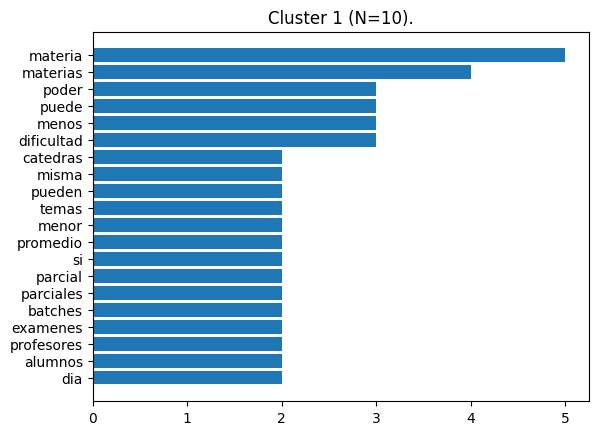

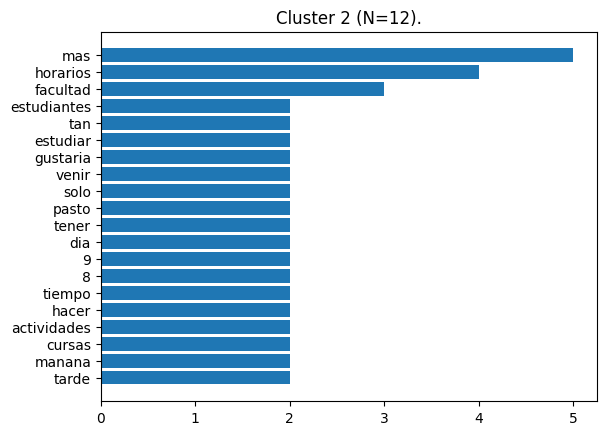

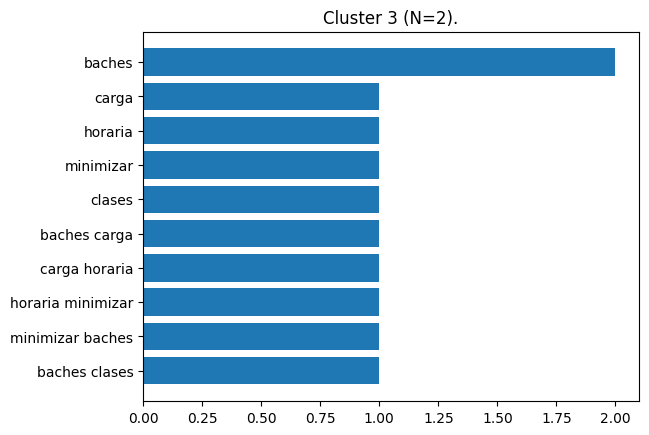

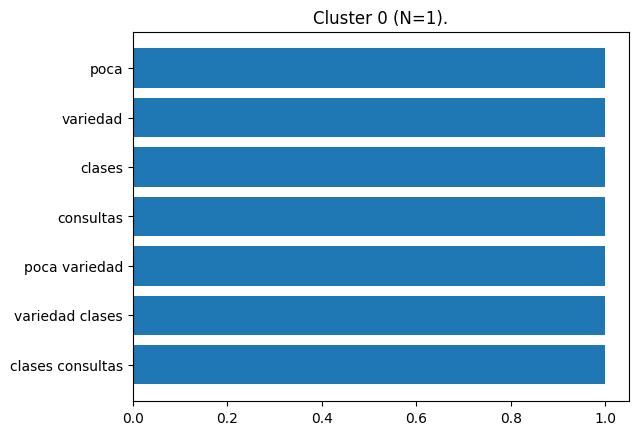

In [403]:
pp_object_transformers = Preprocess(lemma=False, stopwords=False, alphanumeric=False, join=False)
pp_object_word_count = Preprocess(lemma=False)

mrd.plot_word_counts(data, n_clusters=n_clusters, pp_object_transformers=pp_object_transformers, pp_object_word_count=pp_object_word_count)
# mrd_cluster.plot_word_counts(data, n_clusters=n_clusters, pp_object_transformers=pp_object_transformers, pp_object_word_count=pp_object_word_count)

## Finding optimum K
Eje X: numero de clusters

Eje Y: Sum of Squared Distance de cada punto con su centroide

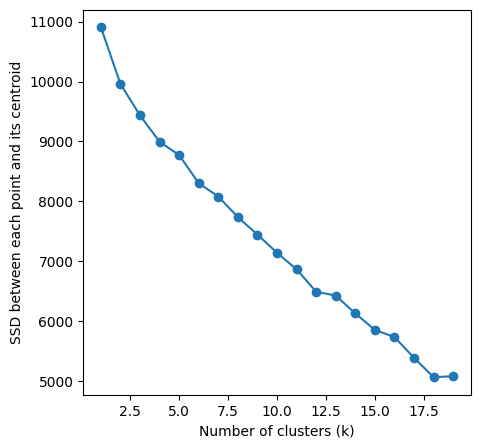

In [222]:
mrd.elbow_method(data, k_range=[1, 20], pp_object=pp_object)

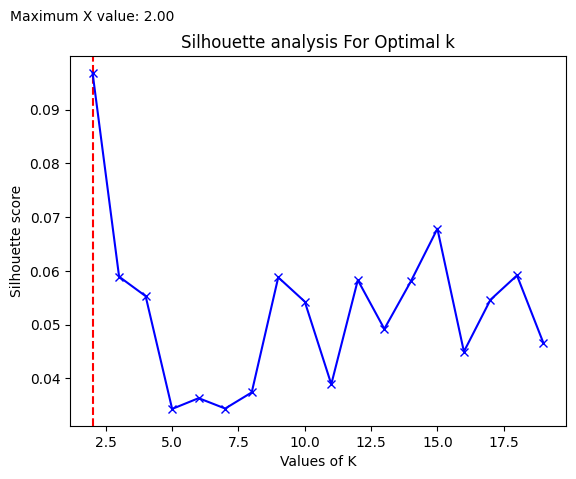

In [223]:
mrd.plot_elbow_silhouette_score(range_n_clusters=[2,20])

## Clusters: Size and Shape

ATENCION: 

debido a que primero se realiza una reduccion de dimensiones, el tamaño y la forma de cada cluster del gráfico puede ser distinto al encontrado en la realidad.

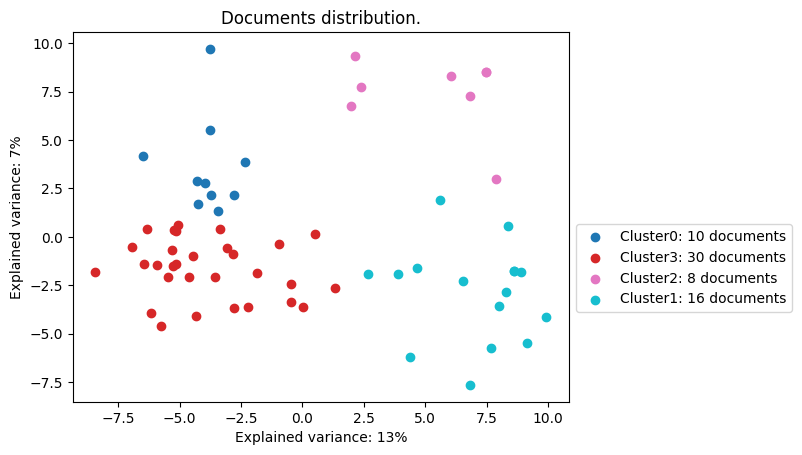

In [62]:
mrd.visualize_documents_kmeans(data, n_clusters=n_clusters, pp_object=pp_object)

# Combination: summarization for each topic's cluster

Apply T5 and BETO summarization to each cluster

In [9]:
# Models
beto = BETOSummary()
t5 = T5Summary()
mrd = MostRepresentativeDocs()

ckpt:
mrm8488/bert2bert_shared-spanish-finetuned-summarization


The following encoder weights were not tied to the decoder ['bert/pooler']
The following encoder weights were not tied to the decoder ['bert/pooler']


ckpt:
josmunpen/mt5-small-spanish-summarization


In [45]:
desafio = '18'
data = df.query(f'desafio == "{desafio}"')['texto'].values
pp_object = Preprocess(lemma=False, stopwords=False, alphanumeric=False, join=False)

In [46]:
labeled_docs = mrd.cluster_and_label_original_docs(data, 5, pp_object)

for key, values in labeled_docs.items():
    values = pp_object.preprocess(values)
    text = '.\n'.join(values)
    print(f'BERT, Cluster {key}:\n{beto.generate_summary(text)}\n\n')
    sleep(2)
    print(f'T5, Cluster {key}:\n{t5.generate_summary(text)}\n\n')

BERT, Cluster 4:
['Los horarios de limpieza de los banos. La carga horaria, hay periodo en los que ni siquiera tengo tiempo de almorzar', 'Los horarios de limpieza de los banos. La carga horaria, hay días en los que ni siquiera tengo tiempo para almorzar y en general']


T5, Cluster 4:
['la carga horaria y los horarios de limpieza de los banos', 'la carga horaria y los horarios de limpieza de los banos']


BERT, Cluster 3:
['Las materias del ciclo de fundamentos no tienen que ver con mi carrera, los horarios, el cansansio y la exigencia sostenida durante el ano.', 'La falta de apoyo par varios de los alunos ( 4 horas de diferencia ) para adaptarse en los pmieros anos']


T5, Cluster 3:
['la falta de apoyo a las materias del ciclo de fundamentos', 'la falta de apoyo a las materias del ciclo de fundamentos']


BERT, Cluster 1:
['Las clases en dh tienen mucho potencial pero dejan mucho que desear', 'Las clases en dh tienen mucho potencial pero dejan mucho que desear']


T5, Cluster 1:
['l

# Sample representative docs

In [31]:
desafio = '17'

documents = df[df['desafio']==desafio]['texto'].values

pp_object = Preprocess(lemma=False, stopwords=False, alphanumeric=False, join=False)

sr = SampleRepresentatives()
res = sr.get_sample(documents, pp_object=pp_object, n_clusters=5)

In [32]:
print(f'Desafio: {desafio}')
for key, value in res.items():
    print(f'\nCluster: {key}\n')
    for v in value[:3]:
        print(v)

Desafio: 17

Cluster: 1

Menos tareas extracurriculares ya que tenemos mucha carga horaria de cursada
mantas en la biblioteca.
Mejores horarios de cursada (menos baches).

Cluster: 3

Horarios mas normales
Horarios más estructurados, que sean o en la mañana o en la tarde, que estén juntos, y que estén distribuidos de forma uniforme a lo largo de la semana. 
más horarios de combis.

Cluster: 0

Comida sin harina en el kiosco 
Mesa de ping pong, canchita de futbol tenis y mesa teqball (es la mesa tipo ping pong para jugar con pelota de futbol)
más comidas hechas como tartas, ensaladas, etc

Cluster: 2

Estaria bueno que la experiencia 2023 tuviese clases magatrales mas pequeñas, de todas maneras me encanto como se dicto esta materia
Más sillitas para sentarse en el campus, más espacios con sombra natural, horarios de la combi más puntuales (desde la estación victoria siempre algún retraso tiene y eso hace que lleguemos tarde a clases)
La cursada sea menor, es decir, entiendo que el nivel